In [34]:
import pandas as pd
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

# Set the checkpoint directory.
MODEL_CKPT_DIR = 'model_params_big_test'
MODEL_CKPT_DIR = 'res_balanced_accuracy'
# MODEL_CKPT_DIR = 'res_f1'

# Paths to the saved model and scaler.
xgb_model_path = Path(MODEL_CKPT_DIR) / 'xgboost_model.json'
scaler_path = Path(MODEL_CKPT_DIR) / 'std_scaler.bin'

# Load the scaler and the pre-trained XGBoost model.
scaler = joblib.load(scaler_path)
model = xgb.XGBClassifier()
model.load_model(xgb_model_path)

/home/anton/micromamba/envs/competitors-xgb/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
DATA_FILE = Path(MODEL_CKPT_DIR) / 'data.csv'

# > AVERAGE FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_all_query_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query_pairs.csv'

# > GOOD FILES HERE
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_pairs.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-5_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-20_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_pairs.csv'

# > FILES W/INNER RUCLIP AS RANKER
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-30_query-2_nonquery-6_embedded.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-20query-23_nonquery-5539_embedded_sbert=all-distilroberta-v1_clip=siamese_contrastive.pt.csv'
# DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-20_query-2_nonquery-6_embedded_sbert=all-distilroberta-v1_clip=siamese_contrastive.pt_final-embs.csv'
DATA_FILE = 'data/tables_OZ_geo_5500/tabular_OZ_geo_5500_top-50_query-23_nonquery-5539_embedded_sbert=all-distilroberta-v1_clip=siamese_contrastive.pt_final-embs.csv'

df_all = pd.read_csv(DATA_FILE)
# df_all.columns.tolist()

In [36]:
N_SKU = 23

all_sku = df_all.sku_first.unique()
subset_sku = pd.Series(all_sku)\
    .sample(min(N_SKU, len(all_sku)), random_state=42).tolist()
df = df_all[df_all['sku_first'].isin(subset_sku)]

print(f'Total Query SKU: {df.sku_first.nunique()}/{df_all.sku_first.nunique()}')
print(f'Total columns: {len(df.columns)}')
df.columns.tolist()

Total Query SKU: 23/23
Total columns: 35


['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'description_first',
 'name_first',
 'options_first',
 'sku_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'description_second',
 'name_second',
 'options_second',
 'sku_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'image_id_first',
 'image_id_second',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [37]:
# Separate the true labels from the dataset.
if 'label' in df.columns:
    y_true = df['label']

# Define the columns that were not used as features during training.
columns_to_drop = [
    'sku_first', 'sku_second',
    'name_first', 'description_first',
    'name_second', 'description_second',
    'options_first', 'options_second',
    'image_url_first', 'image_url_second',
    'image_id_first', 'image_id_second',
    'label'
]

# Create a DataFrame for scaling by dropping the extra columns.
# The original df remains unchanged.
X = df.drop(columns=columns_to_drop, errors='ignore')

# Ensure the columns match exactly what the scaler was trained on.
# The scaler's attribute 'feature_names_in_' holds the expected column names.
if hasattr(scaler, 'feature_names_in_'):
    expected_features = list(scaler.feature_names_in_)
    X_for_scaler = df[expected_features]
else:
    X_for_scaler = df

# print("Columns used for scaling:", X_for_scaler.columns.tolist())

# Scale the features using the loaded scaler.
X_scaled = scaler.transform(X_for_scaler)
X.columns.tolist()

['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [38]:
[
 # призаначены для первой таблицы
 'balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',

# призаначены для второй таблицы
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',

 # одинаковые для обеих таблиц
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',

# ссылки на изображения
 'url_first',
 'url_second',

# расстояния между эмбеддингами
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim'
]

['balance_first',
 'sales_first',
 'rating_first',
 'final_price_first',
 'comments_first',
 'has_video_first',
 'photo_count_first',
 'balance_second',
 'sales_second',
 'rating_second',
 'final_price_second',
 'comments_second',
 'has_video_second',
 'photo_count_second',
 'iseq_vendor',
 'iseq_color',
 'iseq_brand',
 'iseq_supp',
 'are_related',
 'url_first',
 'url_second',
 'desc_sim',
 'opt_sim',
 'name_sim',
 'img_sim']

In [39]:
import pandas as pd

# Compute predictions and probabilities (using your pre-trained model)
predictions = model.predict(X_scaled)
predicted_probas = model.predict_proba(X_scaled)

# For binary classification, use the positive class probability;
# for multiclass, use the highest probability of any class.
if predicted_probas.shape[1] == 2:
    sort_probas = predicted_probas[:, 1]
else:
    sort_probas = predicted_probas.max(axis=1)

# Create a DataFrame with the predictions and probabilities.
# We align by the original dataframe's index.
results_df = pd.DataFrame({
    'prediction': predictions,
    'proba': sort_probas
}, index=df.index)

# Concatenate the predictions to the original DataFrame.
df_with_preds = pd.concat([df, results_df], axis=1)

# Instead of using groupby.apply (with include_groups), sort directly:
df_grouped_sorted = df_with_preds.sort_values(
    by=['sku_first', 'proba'], ascending=[True, False]
)

print("Data grouped by sku_first and sorted within each group by probability:")
df_grouped_sorted.columns.tolist()

matches_df = df_grouped_sorted.copy()
matches_df['price_delta_abs'] = matches_df['final_price_first'] - matches_df['final_price_second']
matches_df['price_delta_rel'] = (
    (matches_df['final_price_first'] - matches_df['final_price_second'])
    / matches_df['final_price_first']
).abs()

matches_df = matches_df[matches_df.prediction == 1]

matches_df_short = matches_df[[
    'sku_first', 'sku_second', 'prediction', 'proba',
    'url_first', 'url_second'
]]
matches_df_short.head()

Data grouped by sku_first and sorted within each group by probability:


,sku_first,sku_second,prediction,proba,url_first,url_second
303,491268805,857968654,1,0.985831,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/857968654/
317,491268805,853771898,1,0.984913,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/853771898/
335,491268805,856985388,1,0.984800,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/856985388/
301,491268805,854403374,1,0.975333,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/854403374/
311,491268805,853831334,1,0.973358,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/853831334/


In [40]:
from pathlib import Path
import pandas as pd

DATA_PATH = 'data'

file_path = (
    Path(DATA_PATH) /
    Path('tables_OZ_geo_5500') /
    'Ozon_Crawler_Latest_info2025-04-07-12-57-51.xlsx'
)

descr_source_df = pd.read_excel(file_path)
descr_source_df.columns.tolist()

['Sku (Sku)',
 'Фото (CoverImage)',
 'Название товара (ProductName)',
 'Продавец (SellerName)',
 'Бренд (BrandName)',
 'Название категории (CategoryName)',
 'Цена соинвест (DiscountPrice)',
 'Цена по карте (OzonCardPrice)',
 'Сток FBO (StockFbm)',
 'Сток FBS (StockFbs)',
 'Ошибка загрузки (CrawlerError)',
 'Валюта (Currency)',
 'Цена до скидки (BasePrice)',
 'Рейтинг товара (AvgRating)',
 'Количество отзывов (Reviews)',
 'Описание (Description)',
 'Rich-контент (RichContent)',
 'Ссылка на карточку',
 'SellerProductId (SellerProductId)']

In [41]:
matches_df[['balance_first', 'balance_second']].describe()

,balance_first,balance_second
count,203.000000,203.000000
mean,91.596059,92.231527
std,173.433396,167.859119
min,0.000000,0.000000
25%,0.000000,12.500000
50%,29.000000,53.000000
75%,110.000000,98.000000
max,899.000000,999.000000


In [48]:
TOP_K = 5
DISPLAY_STATS = True
DISPLAY_NAME = True

for query_idx, (query_sku, query_df) in enumerate(matches_df.groupby('sku_first')):
    print(f'Query #{query_idx} '+'#' * 40)
    print(f"Query SKU: {query_sku}")
    print(f'Query URL: {query_df['url_first'].iloc[0]}')

    if DISPLAY_NAME:
        print(f"Query Name: {query_df['name_first'].iloc[0]}")
        # print(f"Query Description: {query_df['description_first'].iloc[0]}")

    if DISPLAY_STATS:
        display(query_df[[
            'balance_first',
            'comments_first',
            'rating_first',
            'comments_first'
        ]].iloc[0].to_frame().T)

    print('-' * 60)
    for top_k_idx, row in query_df.reset_index(drop=True).iterrows():
        if top_k_idx == TOP_K-1:
            break
        print(f"Top-{top_k_idx} SKU: {row['sku_second']}")
        print(f'Top-{top_k_idx} URL: {row['url_second']}')

        if DISPLAY_NAME:
            print(f'Top-{top_k_idx} Name: {row['name_second']}')
            # print(f'Top-{top_k_idx} Description: {row['description_second']}')

        if DISPLAY_STATS:
            display(row[['balance_second',
                        'comments_second',
                        'rating_second',
                        'comments_second'
                        ]].to_frame().T)
        print()
        
    print()

# TODO: исключить карты, которые не в наличии?

Query #0 ########################################
Query SKU: 491268805
Query URL: https://www.ozon.ru/context/detail/id/491268805/
Query Name: Карта Москвы настенная,100х70 см "Москва современная с линиями метро"


,balance_first,comments_first,rating_first,comments_first
303,233.0,606.0,4.8,606.0


------------------------------------------------------------
Top-0 SKU: 857968654
Top-0 URL: https://www.ozon.ru/context/detail/id/857968654/
Top-0 Name: Карта настенная Санкт-Петербург. 70х100см, выпуск 2025год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
0,144,855,4.9,855



Top-1 SKU: 853771898
Top-1 URL: https://www.ozon.ru/context/detail/id/853771898/
Top-1 Name: Карта Санкт-Петербург-центр города, с достопримечательностями, складная. В развороте 63х47,5см, выпуск 2024год.


,balance_second,comments_second,rating_second,comments_second
1,32,605,4.9,605



Top-2 SKU: 856985388
Top-2 URL: https://www.ozon.ru/context/detail/id/856985388/
Top-2 Name: Физическая карта России, настенная. Россия в новых границах. 100х70см, выпуск 2024год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
2,201,3062,4.9,3062



Top-3 SKU: 854403374
Top-3 URL: https://www.ozon.ru/context/detail/id/854403374/
Top-3 Name: Карта настенная Санкт-Петербург, ламинированная. 107х158см, выпуск 2025год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
3,37,855,4.9,855




Query #1 ########################################
Query SKU: 491270369
Query URL: https://www.ozon.ru/context/detail/id/491270369/
Query Name: Географическая карта России настенная 102х160 см, Выпуск 2024 года, НОВЫЕ ГРАНИЦЫ Школьная карта по географии для детей


,balance_first,comments_first,rating_first,comments_first
57,899.0,1257.0,4.8,1257.0


------------------------------------------------------------
Top-0 SKU: 1919437475
Top-0 URL: https://www.ozon.ru/context/detail/id/1919437475/
Top-0 Name: Карта России физическая ламинированная настенная 190х107 см


,balance_second,comments_second,rating_second,comments_second
0,98,656,4.8,656



Top-1 SKU: 1421565737
Top-1 URL: https://www.ozon.ru/context/detail/id/1421565737/
Top-1 Name: Двухсторонняя политико-административная карта мира и России 158х107 см на отвесах, настенная с новыми границами в тубусе "АГТ Геоцентр"


,balance_second,comments_second,rating_second,comments_second
1,76,4,5.0,4



Top-2 SKU: 646888301
Top-2 URL: https://www.ozon.ru/context/detail/id/646888301/
Top-2 Name: Настенная политико-административная карта России Globen (масштаб 1:8.5 млн) 1010x700мм, интерактивная (КН034)


,balance_second,comments_second,rating_second,comments_second
2,166,0,0.0,0



Top-3 SKU: 178726257
Top-3 URL: https://www.ozon.ru/context/detail/id/178726257/
Top-3 Name: Карта России. Новые границы. 156х101 см. Ламинированная. Политическая. Настенная карта. ДИЭМБИ.


,balance_second,comments_second,rating_second,comments_second
3,116,203,5.0,203




Query #2 ########################################
Query SKU: 491271284
Query URL: https://www.ozon.ru/context/detail/id/491271284/
Query Name: Физическая карта Мира настенная, 157х107см, Выпуск 2024 год


,balance_first,comments_first,rating_first,comments_first
480,62.0,1483.0,4.8,1483.0


------------------------------------------------------------
Top-0 SKU: 1421559792
Top-0 URL: https://www.ozon.ru/context/detail/id/1421559792/
Top-0 Name: Двухсторонняя политико-административная карта мира и России 158х107 см на отвесах, настенная с новыми границами в тубусе "АГТ Геоцентр"


,balance_second,comments_second,rating_second,comments_second
0,65,25,5.0,25



Top-1 SKU: 1421565737
Top-1 URL: https://www.ozon.ru/context/detail/id/1421565737/
Top-1 Name: Двухсторонняя политико-административная карта мира и России 158х107 см на отвесах, настенная с новыми границами в тубусе "АГТ Геоцентр"


,balance_second,comments_second,rating_second,comments_second
1,76,4,5.0,4



Top-2 SKU: 865286119
Top-2 URL: https://www.ozon.ru/context/detail/id/865286119/
Top-2 Name: Карта мира настенная, ламинированная/политическая 1:25 /размер 143х102см/ новые границы


,balance_second,comments_second,rating_second,comments_second
2,54,93,4.9,93



Top-3 SKU: 470870231
Top-3 URL: https://www.ozon.ru/context/detail/id/470870231/
Top-3 Name: Большая настенная карта мира политическая с новыми границами в тубусе, масштаб 1:17 млн., для офиса, школы, дома, АГТ Геоцентр


,balance_second,comments_second,rating_second,comments_second
3,93,24,5.0,24




Query #3 ########################################
Query SKU: 491271339
Query URL: https://www.ozon.ru/context/detail/id/491271339/
Query Name: Карта Москвы "Moscow Today" 70х100 см, на английском языке


,balance_first,comments_first,rating_first,comments_first
972,4.0,196.0,4.8,196.0


------------------------------------------------------------
Top-0 SKU: 765452251
Top-0 URL: https://www.ozon.ru/context/detail/id/765452251/
Top-0 Name: Интерактивная карта мира политическая/ 117 х 80 см/ 1:28 млн/ ламинированная / Shop-tag


,balance_second,comments_second,rating_second,comments_second
0,5,0,0.0,0



Top-1 SKU: 1635104278
Top-1 URL: https://www.ozon.ru/context/detail/id/1635104278/
Top-1 Name: Карта России настенная для детей Globen 1010х690 мм, интерактивная, с ламинацией (КН013)


,balance_second,comments_second,rating_second,comments_second
1,15,0,0.0,0



Top-2 SKU: 1011787050
Top-2 URL: https://www.ozon.ru/context/detail/id/1011787050/
Top-2 Name: Настенная карта Мир политическая 1:25млн.,1,43х1,02м. - 1 ШТ.


,balance_second,comments_second,rating_second,comments_second
2,0,1,5.0,1



Top-3 SKU: 376669001
Top-3 URL: https://www.ozon.ru/context/detail/id/376669001/
Top-3 Name: Настенная карта Мир политическая 1:25млн.,1,43х1,02м.


,balance_second,comments_second,rating_second,comments_second
3,9,0,0.0,0




Query #4 ########################################
Query SKU: 491271768
Query URL: https://www.ozon.ru/context/detail/id/491271768/
Query Name: Карта Москвы, Путеводитель по Москве 100х70 см


,balance_first,comments_first,rating_first,comments_first
682,74.0,196.0,4.8,196.0


------------------------------------------------------------
Top-0 SKU: 853831334
Top-0 URL: https://www.ozon.ru/context/detail/id/853831334/
Top-0 Name: Карта города для водителей Санкт-Петербург, складная. В развороте 69х95,6см, выпуск 2024год.


,balance_second,comments_second,rating_second,comments_second
0,44,608,4.9,608



Top-1 SKU: 854403374
Top-1 URL: https://www.ozon.ru/context/detail/id/854403374/
Top-1 Name: Карта настенная Санкт-Петербург, ламинированная. 107х158см, выпуск 2025год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
1,37,855,4.9,855



Top-2 SKU: 857968654
Top-2 URL: https://www.ozon.ru/context/detail/id/857968654/
Top-2 Name: Карта настенная Санкт-Петербург. 70х100см, выпуск 2025год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
2,144,855,4.9,855



Top-3 SKU: 856985388
Top-3 URL: https://www.ozon.ru/context/detail/id/856985388/
Top-3 Name: Физическая карта России, настенная. Россия в новых границах. 100х70см, выпуск 2024год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
3,201,3062,4.9,3062




Query #5 ########################################
Query SKU: 491273438
Query URL: https://www.ozon.ru/context/detail/id/491273438/
Query Name: Карта России 100х70 см, физическая карта с природными зонами, животными и растениями, НОВЫЕ ГРАНИЦЫ


,balance_first,comments_first,rating_first,comments_first
526,357.0,1262.0,4.8,1262.0


------------------------------------------------------------
Top-0 SKU: 1716671407
Top-0 URL: https://www.ozon.ru/context/detail/id/1716671407/
Top-0 Name: Карта Крыма настенная. Севастополь, Симферополь.


,balance_second,comments_second,rating_second,comments_second
0,37,326,4.7,326



Top-1 SKU: 879462189
Top-1 URL: https://www.ozon.ru/context/detail/id/879462189/
Top-1 Name: Скретч карта 60 уникальных мест России (96х60 cм) с серебряным стираемым слоем, с достопримечательностями и новыми регионами ДНР, ЛНР, Херсонская и Запорожская области (без аксессуаров)


,balance_second,comments_second,rating_second,comments_second
1,94,226,5.0,226



Top-2 SKU: 847647035
Top-2 URL: https://www.ozon.ru/context/detail/id/847647035/
Top-2 Name: Настенная Административная карта Московской области 1:280/размер 143х102см


,balance_second,comments_second,rating_second,comments_second
2,46,37,5.0,37



Top-3 SKU: 1919282160
Top-3 URL: https://www.ozon.ru/context/detail/id/1919282160/
Top-3 Name: Карта России большая настенная физическая 190х107 см


,balance_second,comments_second,rating_second,comments_second
3,100,656,4.8,656




Query #6 ########################################
Query SKU: 491273791
Query URL: https://www.ozon.ru/context/detail/id/491273791/
Query Name: Физическая карта России настенная, 160 х 102 см, Выпуск 2024 год


,balance_first,comments_first,rating_first,comments_first
184,129.0,1261.0,4.8,1261.0


------------------------------------------------------------
Top-0 SKU: 1598283510
Top-0 URL: https://www.ozon.ru/context/detail/id/1598283510/
Top-0 Name: Карта России на стену, складная, политическая, 2025, для путешествий, большая для детей.


,balance_second,comments_second,rating_second,comments_second
0,179,249,4.8,249



Top-1 SKU: 178726257
Top-1 URL: https://www.ozon.ru/context/detail/id/178726257/
Top-1 Name: Карта России. Новые границы. 156х101 см. Ламинированная. Политическая. Настенная карта. ДИЭМБИ.


,balance_second,comments_second,rating_second,comments_second
1,116,203,5.0,203



Top-2 SKU: 1919437475
Top-2 URL: https://www.ozon.ru/context/detail/id/1919437475/
Top-2 Name: Карта России физическая ламинированная настенная 190х107 см


,balance_second,comments_second,rating_second,comments_second
2,98,656,4.8,656



Top-3 SKU: 490685952
Top-3 URL: https://www.ozon.ru/context/detail/id/490685952/
Top-3 Name: Карта России, большая настенная карта для школы, интерактивная, ГеоДом, размер 230х150 см, с ламинацией, в тубусе


,balance_second,comments_second,rating_second,comments_second
3,843,226,4.9,226




Query #7 ########################################
Query SKU: 491279127
Query URL: https://www.ozon.ru/context/detail/id/491279127/
Query Name: Карта МИРА настенная политическая,160х102 см, Выпуск 2024 года, Школьная географическая карта для детей по географии


,balance_first,comments_first,rating_first,comments_first
0,649.0,1719.0,4.9,1719.0


------------------------------------------------------------
Top-0 SKU: 1294181688
Top-0 URL: https://www.ozon.ru/context/detail/id/1294181688/
Top-0 Name: Карта мира 2024 большая настенная политическая 210х107 см


,balance_second,comments_second,rating_second,comments_second
0,83,656,4.8,656



Top-1 SKU: 1713036930
Top-1 URL: https://www.ozon.ru/context/detail/id/1713036930/
Top-1 Name: Карта мира политическая на стену большая 101х71 см, 1:32М, на рейках, с ламинацией, интерактивная, европодвес, Brauberg


,balance_second,comments_second,rating_second,comments_second
1,27,753,4.8,753




Query #8 ########################################
Query SKU: 492260072
Query URL: https://www.ozon.ru/context/detail/id/492260072/
Query Name: Атлас автомобильных дорог России 2023 "Из Москвы на Юг", 70х100 см, складная


,balance_first,comments_first,rating_first,comments_first
768,0.0,143.0,4.8,143.0


------------------------------------------------------------
Top-0 SKU: 1408330333
Top-0 URL: https://www.ozon.ru/context/detail/id/1408330333/
Top-0 Name: Карта Украина, складная. В развороте 69х95,6см, выпуск 2023год.


,balance_second,comments_second,rating_second,comments_second
0,88,996,4.9,996



Top-1 SKU: 853804528
Top-1 URL: https://www.ozon.ru/context/detail/id/853804528/
Top-1 Name: Карта города для водителей Санкт-Петербург и Ленинградская область, складная. В развороте 69х95,6см, выпуск 2024год.


,balance_second,comments_second,rating_second,comments_second
1,71,608,4.9,608



Top-2 SKU: 856985388
Top-2 URL: https://www.ozon.ru/context/detail/id/856985388/
Top-2 Name: Физическая карта России, настенная. Россия в новых границах. 100х70см, выпуск 2024год. Карта в тубусе.


,balance_second,comments_second,rating_second,comments_second
2,201,3062,4.9,3062



Top-3 SKU: 853831334
Top-3 URL: https://www.ozon.ru/context/detail/id/853831334/
Top-3 Name: Карта города для водителей Санкт-Петербург, складная. В развороте 69х95,6см, выпуск 2024год.


,balance_second,comments_second,rating_second,comments_second
3,44,608,4.9,608




Query #9 ########################################
Query SKU: 494562010
Query URL: https://www.ozon.ru/context/detail/id/494562010/
Query Name: Двусторонняя Карта Мира и России политическая, 70 х 100 см. Складная, школьная карта. Выпуск 2024


,balance_first,comments_first,rating_first,comments_first
809,46.0,196.0,4.8,196.0


------------------------------------------------------------
Top-0 SKU: 178726257
Top-0 URL: https://www.ozon.ru/context/detail/id/178726257/
Top-0 Name: Карта России. Новые границы. 156х101 см. Ламинированная. Политическая. Настенная карта. ДИЭМБИ.


,balance_second,comments_second,rating_second,comments_second
0,116,203,5.0,203



Top-1 SKU: 601557370
Top-1 URL: https://www.ozon.ru/context/detail/id/601557370/
Top-1 Name: Карта мира и России двухсторонняя настенная политическая в тубусе, 90х60 см, для дома, школы, офиса, "АГТ Геоцентр"


,balance_second,comments_second,rating_second,comments_second
1,77,171,5.0,171



Top-2 SKU: 861723214
Top-2 URL: https://www.ozon.ru/context/detail/id/861723214/
Top-2 Name: Карта мира географическая политическая интерактивная с ламинацией, 157 х 107 см, 1:21,5М, ламинированная, настенная


,balance_second,comments_second,rating_second,comments_second
2,303,5227,4.8,5227



Top-3 SKU: 490685952
Top-3 URL: https://www.ozon.ru/context/detail/id/490685952/
Top-3 Name: Карта России, большая настенная карта для школы, интерактивная, ГеоДом, размер 230х150 см, с ламинацией, в тубусе


,balance_second,comments_second,rating_second,comments_second
3,843,226,4.9,226




Query #10 ########################################
Query SKU: 507113963
Query URL: https://www.ozon.ru/context/detail/id/507113963/
Query Name: Настенная физико-политическая карта Европы 158х118 см, 1:3 800 000, школьная карта


,balance_first,comments_first,rating_first,comments_first
936,0.0,11.0,0.0,11.0


------------------------------------------------------------
Top-0 SKU: 1030259077
Top-0 URL: https://www.ozon.ru/context/detail/id/1030259077/
Top-0 Name: Политическая карта мира (2022 год), глянцевая ламинация


,balance_second,comments_second,rating_second,comments_second
0,78,14,4.5,14



Top-1 SKU: 1449501817
Top-1 URL: https://www.ozon.ru/context/detail/id/1449501817/
Top-1 Name: Политическая карта мира (2022 год), матовая ламинация


,balance_second,comments_second,rating_second,comments_second
1,100,14,4.5,14



Top-2 SKU: 1449500440
Top-2 URL: https://www.ozon.ru/context/detail/id/1449500440/
Top-2 Name: Политическая карта мира (2022 год), матовая ламинация


,balance_second,comments_second,rating_second,comments_second
2,100,14,4.5,14



Top-3 SKU: 1030259834
Top-3 URL: https://www.ozon.ru/context/detail/id/1030259834/
Top-3 Name: Политическая карта мира (2022 год), глянцевая ламинация


,balance_second,comments_second,rating_second,comments_second
3,97,14,4.5,14




Query #11 ########################################
Query SKU: 508611672
Query URL: https://www.ozon.ru/context/detail/id/508611672/
Query Name: Карта Москвы и Московской области настенная 143х102см, административная карта столицы России


,balance_first,comments_first,rating_first,comments_first
201,141.0,606.0,4.8,606.0


------------------------------------------------------------
Top-0 SKU: 552996497
Top-0 URL: https://www.ozon.ru/context/detail/id/552996497/
Top-0 Name: Настенная административная карта Москвы и Московской области (масштаб 1:280 000)


,balance_second,comments_second,rating_second,comments_second
0,11,3,5.0,3



Top-1 SKU: 552996193
Top-1 URL: https://www.ozon.ru/context/detail/id/552996193/
Top-1 Name: Настенная административная карта Москвы и Московской области (масштаб 1:270 000)


,balance_second,comments_second,rating_second,comments_second
1,10,1,5.0,1




Query #12 ########################################
Query SKU: 824158517
Query URL: https://www.ozon.ru/context/detail/id/824158517/
Query Name: Политическая карта МИРА настенная, 100х70см, новые границы, выпуск 2024 год


,balance_first,comments_first,rating_first,comments_first
428,686.0,1483.0,4.8,1483.0


------------------------------------------------------------
Top-0 SKU: 671211267
Top-0 URL: https://www.ozon.ru/context/detail/id/671211267/
Top-0 Name: Интерактивная карта мира политическая, 117 х 80 см, 1:28 млн


,balance_second,comments_second,rating_second,comments_second
0,30,289,4.6,289




Query #13 ########################################
Query SKU: 922229770
Query URL: https://www.ozon.ru/context/detail/id/922229770/
Query Name: Карта России настенная политическая, в тубусе 100х70см, Карта России настенная


,balance_first,comments_first,rating_first,comments_first
1043,29.0,29.0,5.0,29.0


------------------------------------------------------------
Top-0 SKU: 466146204
Top-0 URL: https://www.ozon.ru/context/detail/id/466146204/
Top-0 Name: Карта мира политическая настенная с новыми границами России, 158х107 см, в тубусе, для офиса, школы, дома, "АГТ Геоцентр"


,balance_second,comments_second,rating_second,comments_second
0,79,63,5.0,63



Top-1 SKU: 1320622328
Top-1 URL: https://www.ozon.ru/context/detail/id/1320622328/
Top-1 Name: Настенная Политико-административная карта России 1:3,7 /размер 233х158/новые границы


,balance_second,comments_second,rating_second,comments_second
1,49,62,5.0,62



Top-2 SKU: 467377269
Top-2 URL: https://www.ozon.ru/context/detail/id/467377269/
Top-2 Name: Карта мира политическая настенная с новыми границами России, 158х107 см, на отвесах в тубусе, для офиса, школы, дома, "АГТ Геоцентр"


,balance_second,comments_second,rating_second,comments_second
2,58,63,5.0,63



Top-3 SKU: 1544672427
Top-3 URL: https://www.ozon.ru/context/detail/id/1544672427/
Top-3 Name: 10 шт. Карта "Россия" политико-административная Globen, 1:14,5млн., 600*410мм, интерактивная


,balance_second,comments_second,rating_second,comments_second
3,17,0,0.0,0




Query #14 ########################################
Query SKU: 922230517
Query URL: https://www.ozon.ru/context/detail/id/922230517/
Query Name: Политическая карта МИРА настенная, 160х102см, карта мира по географии, Выпуск 2024 год, В ТУБУСЕ


,balance_first,comments_first,rating_first,comments_first
132,255.0,1486.0,4.8,1486.0


------------------------------------------------------------
Top-0 SKU: 671211264
Top-0 URL: https://www.ozon.ru/context/detail/id/671211264/
Top-0 Name: Интерактивная географическая карта мира политическая 101х70 см 1:32М ламинированная настенная


,balance_second,comments_second,rating_second,comments_second
0,30,2167,4.9,2167



Top-1 SKU: 974294460
Top-1 URL: https://www.ozon.ru/context/detail/id/974294460/
Top-1 Name: Карта мира настенная политическая ламинированная 180х112 см


,balance_second,comments_second,rating_second,comments_second
1,886,339,4.9,339



Top-2 SKU: 671211306
Top-2 URL: https://www.ozon.ru/context/detail/id/671211306/
Top-2 Name: Интерактивная географическая карта Мира физическая Globen, 101 х 66 см, 1:29 млн, ламинированная настенная


,balance_second,comments_second,rating_second,comments_second
2,29,461,4.9,461



Top-3 SKU: 958897185
Top-3 URL: https://www.ozon.ru/context/detail/id/958897185/
Top-3 Name: Настенная физическая карта мира Полушария Brauberg, 101х69см, интерактивная, европодвес, 4шт. (112375)


,balance_second,comments_second,rating_second,comments_second
3,83,1,5.0,1




Query #15 ########################################
Query SKU: 922231521
Query URL: https://www.ozon.ru/context/detail/id/922231521/
Query Name: Политическая карта МИРА настенная, 100х70см, школьная географическая карта мира, Выпуск 2024 год, В ТУБУСЕ


,balance_first,comments_first,rating_first,comments_first
256,110.0,1486.0,4.8,1486.0


------------------------------------------------------------
Top-0 SKU: 1320622328
Top-0 URL: https://www.ozon.ru/context/detail/id/1320622328/
Top-0 Name: Настенная Политико-административная карта России 1:3,7 /размер 233х158/новые границы


,balance_second,comments_second,rating_second,comments_second
0,49,62,5.0,62



Top-1 SKU: 865286119
Top-1 URL: https://www.ozon.ru/context/detail/id/865286119/
Top-1 Name: Карта мира настенная, ламинированная/политическая 1:25 /размер 143х102см/ новые границы


,balance_second,comments_second,rating_second,comments_second
1,54,93,4.9,93



Top-2 SKU: 1857130100
Top-2 URL: https://www.ozon.ru/context/detail/id/1857130100/
Top-2 Name: Настенная карта России с новыми территориями (политико-административная) / размер160х102см


,balance_second,comments_second,rating_second,comments_second
2,14,62,5.0,62



Top-3 SKU: 1125016187
Top-3 URL: https://www.ozon.ru/context/detail/id/1125016187/
Top-3 Name: Настенная карта России (политико-административная) для школы /размер 160х107см/ матовая ламинация


,balance_second,comments_second,rating_second,comments_second
3,99,0,0.0,0




Query #16 ########################################
Query SKU: 1679550303
Query URL: https://www.ozon.ru/context/detail/id/1679550303/
Query Name: Схема линий скоростного транспорта Москвы (Метро, МЦК, МЦД) 0,5*0,7 м, ламинированная


,balance_first,comments_first,rating_first,comments_first
735,169.0,606.0,4.8,606.0


------------------------------------------------------------
Top-0 SKU: 1573965314
Top-0 URL: https://www.ozon.ru/context/detail/id/1573965314/
Top-0 Name: Настенная карта Москвы "Москва современная с линиями метро"/размер 102х143


,balance_second,comments_second,rating_second,comments_second
0,39,4,5.0,4


In [43]:
def construct_wide_table(df, top_k):
    """
    Constructs a wide table such that each row corresponds to a unique query SKU and contains:
    
      Query_SKU, Top-1_SKU, Top-2_SKU, ... Top-k_SKU,
      Query_URL, Top-1_URL, Top-2_URL, ... Top-k_URL,
      Top-1_Proba, Top-2_Proba, ... Top-k_Proba
      
    Only candidates with a positive prediction (prediction == 1) are included.
    If there are fewer than top_k positive predictions for a query, the remaining columns are filled with None.
    """
    wide_rows = []
    # Process each unique query SKU.
    for query_sku, group in df.groupby('sku_first'):
        # Consider only candidates with positive prediction.
        group_positive = group[group['prediction'] == 1]
        # Sort the positive candidates by probability in descending order.
        group_sorted = group_positive.sort_values(by='proba', ascending=False).reset_index(drop=True)
        # Assume the query URL is the same for every row with the same query SKU.
        query_url = group_sorted.loc[0, 'url_first'] if not group_sorted.empty else None
        
        # Build the row dictionary with the desired column order.
        row = {}
        row['Query_SKU'] = query_sku
        
        # Add candidate SKU columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_SKU'] = group_sorted.loc[i, 'sku_second']
            else:
                row[f'Top-{i+1}_SKU'] = None
        
        # Add the Query URL.
        row['Query_URL'] = query_url
        
        # Add candidate URL columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_URL'] = group_sorted.loc[i, 'url_second']
            else:
                row[f'Top-{i+1}_URL'] = None
        
        # Add candidate probability columns.
        for i in range(top_k):
            if i < len(group_sorted):
                row[f'Top-{i+1}_proba'] = group_sorted.loc[i, 'proba']
            else:
                row[f'Top-{i+1}_proba'] = None
        
        wide_rows.append(row)
    return pd.DataFrame(wide_rows)


In [44]:
# --- Set your desired top_k (e.g. 5) and construct the wide table.
TOP_K = 5

matches_wide_df = construct_wide_table(df_grouped_sorted, TOP_K)
matches_wide_df = matches_wide_df.dropna()
matches_wide_df

,Query_SKU,Top-1_SKU,Top-2_SKU,Top-3_SKU,Top-4_SKU,Top-5_SKU,Query_URL,Top-1_URL,Top-2_URL,Top-3_URL,Top-4_URL,Top-5_URL,Top-1_proba,Top-2_proba,Top-3_proba,Top-4_proba,Top-5_proba
0,491268805,8.579687e+08,8.537719e+08,8.569854e+08,8.544034e+08,8.538313e+08,https://www.ozon.ru/context/detail/id/491268805/,https://www.ozon.ru/context/detail/id/857968654/,https://www.ozon.ru/context/detail/id/853771898/,https://www.ozon.ru/context/detail/id/856985388/,https://www.ozon.ru/context/detail/id/854403374/,https://www.ozon.ru/context/detail/id/853831334/,0.985831,0.984913,0.984800,0.975333,0.973358
2,491270369,1.919437e+09,1.421566e+09,6.468883e+08,1.787263e+08,6.469077e+08,https://www.ozon.ru/context/detail/id/491270369/,https://www.ozon.ru/context/detail/id/1919437475/,https://www.ozon.ru/context/detail/id/1421565737/,https://www.ozon.ru/context/detail/id/646888301/,https://www.ozon.ru/context/detail/id/178726257/,https://www.ozon.ru/context/detail/id/646907736/,0.704000,0.620349,0.560837,0.516669,0.516117
3,491271284,1.421560e+09,1.421566e+09,8.652861e+08,4.708702e+08,6.712113e+08,https://www.ozon.ru/context/detail/id/491271284/,https://www.ozon.ru/context/detail/id/1421559792/,https://www.ozon.ru/context/detail/id/1421565737/,https://www.ozon.ru/context/detail/id/865286119/,https://www.ozon.ru/context/detail/id/470870231/,https://www.ozon.ru/context/detail/id/671211267/,0.828432,0.804022,0.799381,0.765026,0.701680
5,491271339,7.654523e+08,1.635104e+09,1.011787e+09,3.766690e+08,4.176194e+08,https://www.ozon.ru/context/detail/id/491271339/,https://www.ozon.ru/context/detail/id/765452251/,https://www.ozon.ru/context/detail/id/1635104278/,https://www.ozon.ru/context/detail/id/1011787050/,https://www.ozon.ru/context/detail/id/376669001/,https://www.ozon.ru/context/detail/id/417619369/,0.956154,0.948914,0.930448,0.921222,0.920474
6,491271768,8.538313e+08,8.544034e+08,8.579687e+08,8.569854e+08,1.629024e+09,https://www.ozon.ru/context/detail/id/491271768/,https://www.ozon.ru/context/detail/id/853831334/,https://www.ozon.ru/context/detail/id/854403374/,https://www.ozon.ru/context/detail/id/857968654/,https://www.ozon.ru/context/detail/id/856985388/,https://www.ozon.ru/context/detail/id/1629023767/,0.949865,0.901499,0.891754,0.890374,0.826007
8,491273791,1.598284e+09,1.787263e+08,1.919437e+09,4.906860e+08,6.015567e+08,https://www.ozon.ru/context/detail/id/491273791/,https://www.ozon.ru/context/detail/id/1598283510/,https://www.ozon.ru/context/detail/id/178726257/,https://www.ozon.ru/context/detail/id/1919437475/,https://www.ozon.ru/context/detail/id/490685952/,https://www.ozon.ru/context/detail/id/601556709/,0.977719,0.943675,0.852875,0.763934,0.724084
10,492260072,1.408330e+09,8.538045e+08,8.569854e+08,8.538313e+08,1.573132e+09,https://www.ozon.ru/context/detail/id/492260072/,https://www.ozon.ru/context/detail/id/1408330333/,https://www.ozon.ru/context/detail/id/853804528/,https://www.ozon.ru/context/detail/id/856985388/,https://www.ozon.ru/context/detail/id/853831334/,https://www.ozon.ru/context/detail/id/1573132450/,0.986067,0.975680,0.962779,0.932112,0.829408
12,507113963,1.030259e+09,1.449502e+09,1.449500e+09,1.030260e+09,1.030310e+09,https://www.ozon.ru/context/detail/id/507113963/,https://www.ozon.ru/context/detail/id/1030259077/,https://www.ozon.ru/context/detail/id/1449501817/,https://www.ozon.ru/context/detail/id/1449500440/,https://www.ozon.ru/context/detail/id/1030259834/,https://www.ozon.ru/context/detail/id/1030309559/,0.987020,0.975414,0.975414,0.975414,0.960574
16,922229770,4.661462e+08,1.320622e+09,4.673773e+08,1.544672e+09,1.633444e+09,https://www.ozon.ru/context/detail/id/922229770/,https://www.ozon.ru/context/detail/id/466146204/,https://www.ozon.ru/context/detail/id/1320622328/,https://www.ozon.ru/context/detail/id/467377269/,https://www.ozon.ru/context/detail/id/1544672427/,https://www.ozon.ru/context/detail/id/1633443740/,0.982346,0.953258,0.947267,0.946289,0.946289
18,922230517,6.712113e+08,9.742945e+08,6.712113e+08,9

In [45]:
subset_cols = [
    'Query_SKU',
    # 'Top-1_SKU', 'Top-2_SKU', 'Top-3_SKU', 'Top-4_SKU', 'Top-5_SKU',
    # 'Query_URL',
    # 'Top-1_URL', 'Top-2_URL', 'Top-3_URL', 'Top-4_URL', 'Top-5_URL',
    # 'Top-1_proba', 'Top-2_proba', 'Top-3_proba', 'Top-4_proba', 'Top-5_proba'
]

output_file_path = (
    Path(DATA_FILE).parent /
    Path('test_results') / 
    'result-errors-template.csv'
    # (f'result-errors-template-{MODEL_CKPT_DIR}_' + Path(DATA_FILE).name)
)
matches_wide_df.to_clipboard(index=False, header=True, excel=True, columns=subset_cols)
matches_wide_df.to_csv(output_file_path, index=False, header=True, columns=subset_cols)

In [46]:
DATA_PATH = 'data'

output_file_path = (
    Path(DATA_FILE).parent /
    Path('test_results') / 
    (f'result-{MODEL_CKPT_DIR}_' + Path(DATA_FILE).name)
)
output_file_path.parent.mkdir(parents=True, exist_ok=True)
# output_file_path

matches_wide_df.to_csv(output_file_path, index=None)

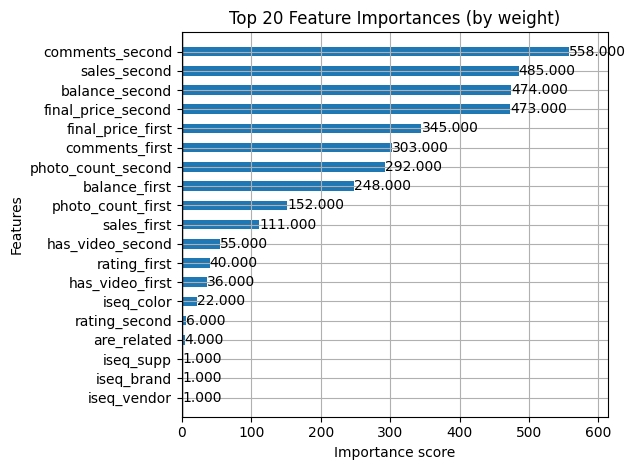

In [47]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assume you already have a scaler and a DataFrame X_for_scaler that were used during training.
# For example, earlier you may have extracted:
# if hasattr(scaler, 'feature_names_in_'):
#     feature_names = list(scaler.feature_names_in_)
# else:
#     feature_names = X_for_scaler.columns.tolist()

if hasattr(scaler, 'feature_names_in_'):
    feature_names = list(scaler.feature_names_in_)
else:
    feature_names = X_for_scaler.columns.tolist()

# Set the original feature names in the booster
booster = model.get_booster()
booster.feature_names = feature_names

# Now plot the feature importance using the booster (which now has the correct names)
ax = xgb.plot_importance(
    booster,
    importance_type='weight',
    max_num_features=20,
    height=0.5,
    show_values=False  # Turn off default text; we'll annotate manually.
)

plt.title("Top 20 Feature Importances (by weight)")
# Optional: Draw a vertical line at x=0 for clarity when some weights are negative.
plt.axvline(x=0, color='black', linewidth=1)

# Label each bar manually so they're formatted nicely.
offset = 0.02  # This offset shifts the label a little to the right.
for patch in ax.patches:
    bar_width = patch.get_width()
    bar_y_center = patch.get_y() + patch.get_height() / 2
    # For positive values, label at the bar's end; for negative, anchor at x=0.
    label_x = bar_width + offset if bar_width >= 0 else 0 + offset
    ax.text(label_x, bar_y_center, f"{bar_width:.3f}", ha='left', va='center')

plt.tight_layout()
plt.show()
